## Black-box Adversarial Attack 
The sample demosntrates creating adversarial attacks using ResNet50 a high precision state-of-the art CNN. 
This used as the surrogate model to target an uknown CNN.  In this case it is MobileNetV2 designed for mobile and IoT scenarios. 
Our attack scenario is an adversary targeting the city's speed cameras and they use
- use a racer car image which is correctly classified by mobileNet. 
- apply FGSM to the imahe using our surrogate ResNet50 model
- use the generated adversarial image, which is misclassified by Mobile Net, demostrating how black box attacks would take place.
This is a simple example with FGM generating a coarce adversarial image. In practice the attackers would use more sophisticated perturbation techniques but the workflow, which the notebook demostrates, would be the same


In [31]:
import numpy as np
import tensorflow as tf
import art
print(f'Tensorflow version {tf.__version__}')
print(f'ART Version {art.__version__}')
import sys
sys.path.append('../lib')
import utils
from utils import show_adversarial_images, predict

Tensorflow version 2.15.1
ART Version 1.17.1


In [32]:
# Load pre-trained target and surrogate models
target_model = tf.keras.applications.MobileNetV2(weights='imagenet')
surrogate_model = tf.keras.applications.ResNet50(weights='imagenet')

In [33]:
# Wrap model with ART classifiers
from art.estimators.classification import TensorFlowV2Classifier
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
classifier_surrogate = TensorFlowV2Classifier(model=surrogate_model, nb_classes=1000, input_shape=(224, 224, 3), clip_values=(0, 255),loss_object=loss_object)

1/1 [==============================] - 0s 334ms/step


[[('n04037443', 'racer', 0.22176462),
  ('n02704792', 'amphibian', 0.10843077),
  ('n04252077', 'snowmobile', 0.041930396),
  ('n04461696', 'tow_truck', 0.037390552),
  ('n03417042', 'garbage_truck', 0.03303081)]]

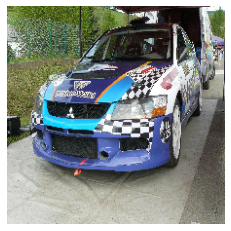

In [34]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
# Get an image and preprocess it
image = utils.load_preprocess('../images/racing-car.jpg', show=True, preprocess=preprocess_input)
utils.model = target_model
utils.predictions(image,top=5)

In [35]:
# Generate adversarial examples on the surrogate model
attack = FastGradientMethod(estimator=classifier_surrogate, eps=8, eps_step=2)
adv_image = attack.generate(x=image)

In [36]:
utils.predictions(adv_image,top=5)

1/1 [==============================] - 0s 15ms/step


[[('n03000247', 'chain_mail', 0.1201529),
  ('n03729826', 'matchstick', 0.094642006),
  ('n03916031', 'perfume', 0.06262689),
  ('n03223299', 'doormat', 0.057201542),
  ('n09229709', 'bubble', 0.049637385)]]

In [37]:
# Apply adversarial examples on target model
predictions = target_model.predict(adv_image)
# Decode predictions
decoded_predictions = tf.keras.applications.mobilenet_v2.decode_predictions(predictions, top=5)
print(decoded_predictions)

1/1 [==============================] - 0s 14ms/step
[[('n03000247', 'chain_mail', 0.1201529), ('n03729826', 'matchstick', 0.094642006), ('n03916031', 'perfume', 0.06262689), ('n03223299', 'doormat', 0.057201542), ('n09229709', 'bubble', 0.049637385)]]
